In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime 
import re
import math
import warnings
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D

warnings.filterwarnings('ignore')

plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

## 1. 데이터 준비

In [2]:
user_info = pd.read_excel("../../data/glowpick_user_info.xlsx")
transaction = pd.read_excel("../../data/glowpick_transaction.xlsx")

transaction["review_date"] = [datetime.strptime(d,"%Y.%m.%d") for d in transaction.review_date]

del user_info["Unnamed: 0"]
del transaction["Unnamed: 0"]

glowpick_df = pd.merge(user_info, transaction, on = "nickname")

In [3]:
user_info

,nickname,age,skin_type,gender
0,기린91,59,건성,여
1,포카리블루,30,민감성,여
2,둘리대장,23,지성,여
3,chick25,30,민감성,여
4,2N,32,복합성,여
...,...,...,...,...
329,판다s,21,복합성,여
330,파카러부,30,복합성,여
331,글로리#RL9NRZ,40,민감성,여
332,고양이실패단_,25,중성,여


In [4]:
transaction

,nickname,brand,product_name,rating,review_date
0,기린91,새한화장품,글로발 체리 미러클 휘니쉬,4,2022-05-14
1,기린91,닥터텅스,스마트 치실,5,2022-05-14
2,기린91,마몽드,로즈 하이드라 글로리 앰플,5,2022-05-14
3,기린91,설화수,자음생크림 소프트,5,2022-05-14
4,기린91,에스티 로더,마이크로 에센스,5,2022-05-14
...,...,...,...,...,...
14770,꽃피움,마녀공장,퓨어 클렌징 오일,4,2020-04-22
14771,꽃피움,마녀공장,허브그린 클렌징 오일,4,2020-04-22
14772,꽃피움,라네즈,크림 스킨,3,2020-04-22
14773,꽃피움,리리코스 마린에너지,카밍 퓨어 워터,3,2020-04-22


## 2. Intro - 리뷰어 특성, 평점 분포 파악

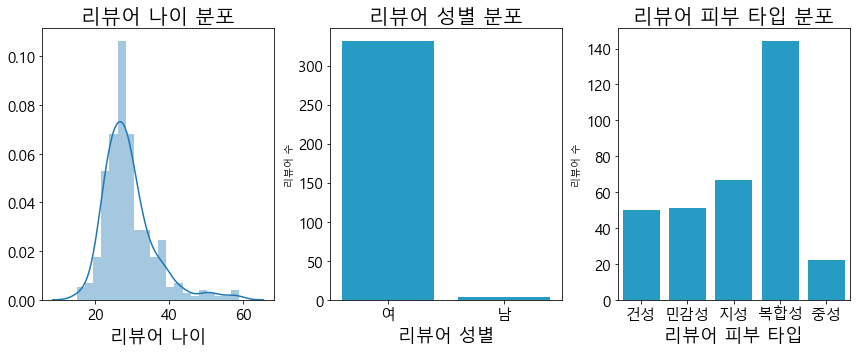

In [5]:
fig, axes = plt.subplots(1,3, figsize = (12,5))

fig.subplots_adjust(wspace = 0.3)


## 그래프 그리기
sns.distplot(user_info.age, ax=axes[0])
sns.countplot(x = "gender" ,data = user_info, ax = axes[1], color = "#0CA8DE")
sns.countplot(x = "skin_type" ,data = user_info, ax = axes[2], color = "#0CA8DE")

## 축 라벨 설정
axes[0].set_title("리뷰어 나이 분포", fontsize = 20)
axes[1].set_title("리뷰어 성별 분포", fontsize = 20)
axes[2].set_title("리뷰어 피부 타입 분포", fontsize = 20)
axes[0].set_xlabel("리뷰어 나이", fontsize = 18)
axes[1].set_xlabel("리뷰어 성별", fontsize = 18)
axes[2].set_xlabel("리뷰어 피부 타입", fontsize = 18)

axes[0].set_ylabel("")
axes[1].set_ylabel("리뷰어 수")
axes[2].set_ylabel("리뷰어 수")

axes[0].tick_params(axis='both', which='major', labelsize=15)
axes[1].tick_params(axis='both', which='major', labelsize=15)
axes[2].tick_params(axis='both', which='major', labelsize=15)

plt.tight_layout()

plt.savefig("user_profile_fig.jpg")

In [6]:
user_info

,nickname,age,skin_type,gender
0,기린91,59,건성,여
1,포카리블루,30,민감성,여
2,둘리대장,23,지성,여
3,chick25,30,민감성,여
4,2N,32,복합성,여
...,...,...,...,...
329,판다s,21,복합성,여
330,파카러부,30,복합성,여
331,글로리#RL9NRZ,40,민감성,여
332,고양이실패단_,25,중성,여


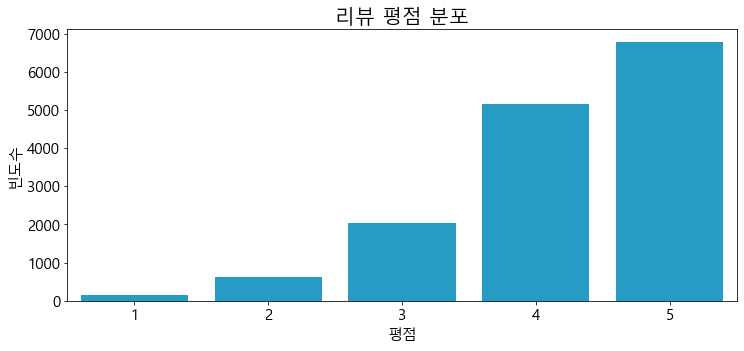

In [7]:
fig, axes = plt.subplots(1,1, figsize = (12,5))

sns.countplot(glowpick_df.rating, ax = axes, color = "#0CA8DE")

axes.set_title("리뷰 평점 분포",  fontsize = 20)
axes.set_xlabel("평점",  fontsize = 15)
axes.set_ylabel("빈도수",  fontsize = 15)

axes.tick_params(axis='both', which='major', labelsize=15)



plt.savefig("user_rating_fig.jpg")

## 3. 리뷰 특성 파악

<집중적으로 파악해 볼 사항들>

* 총 리뷰 작성 수

* 리뷰 작성 주기

* 최근작성한 리뷰 건수를 기준으로 최근 활동 정도 파악

### 3-1. 리뷰어 별 총 리뷰 건수

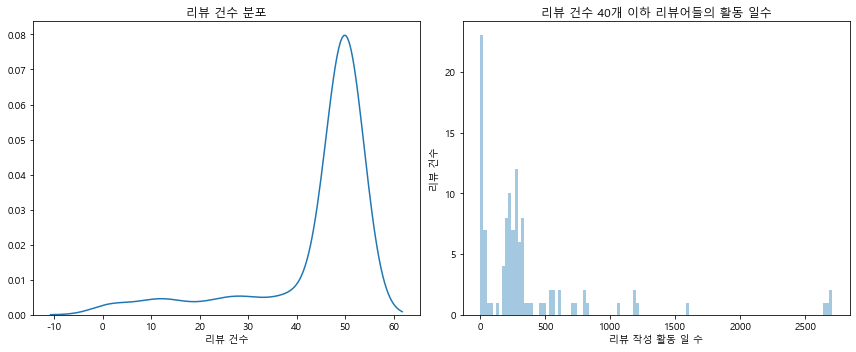

In [8]:
## subplot 설정
fig, axes = plt.subplots(1,2, figsize = (12,5))


## 리뷰 수 분포도 그래프
review_num_df = transaction.groupby("nickname").count()

sns.kdeplot(x = "review_date" , data = review_num_df, ax = axes[0])


## 리뷰 작성 수 40건 이하 유저들 활동 일수 분포도
reviewers_under_40_reviews = review_num_df.loc[review_num_df.review_date <= 40].index

### 리뷰 건수 40건 이하 리뷰어 필터링
idx_list = [idx for idx, nick in enumerate(transaction.nickname) if nick in reviewers_under_40_reviews]
transaction_under_40 =  transaction.iloc[idx_list]
transaction_under_40.index = range(transaction_under_40.shape[0])

## review_num_by_dates 생성 
review_num_by_dates = transaction_under_40.groupby("review_date").count()["nickname"].reset_index()
review_num_by_dates.rename(columns = {"nickname":"number_of_reviews"}, inplace = True)

review_num_by_dates["membership_period"] = [(datetime.strptime("2022-05-14", "%Y-%m-%d") - d).days for d in  review_num_by_dates.review_date]

## transaction 데이터프레임에도 파생선수 생성 (이후 군집화 적용 하기 위해)
transaction["membership_period"] = [(datetime.strptime("2022-05-14", "%Y-%m-%d") - d).days for d in  transaction.review_date]

sns.distplot(review_num_by_dates.membership_period,bins = review_num_by_dates.shape[0] ,kde = False , ax = axes[1])

## 그래프 제목 설정
axes[0].set_title("리뷰 건수 분포")
axes[1].set_title("리뷰 건수 40개 이하 리뷰어들의 활동 일수")

axes[0].set_xlabel("리뷰 건수")
axes[0].set_ylabel("")

axes[1].set_xlabel("리뷰 작성 활동 일 수")
axes[1].set_ylabel("리뷰 건수")



plt.tight_layout()
plt.show()

In [9]:
pd.merge(user_info, review_num_df.review_date.reset_index(), on = "nickname").rename(columns = {"review_date":"total_review_num"})

,nickname,age,skin_type,gender,total_review_num
0,기린91,59,건성,여,10
1,포카리블루,30,민감성,여,50
2,둘리대장,23,지성,여,50
3,chick25,30,민감성,여,50
4,2N,32,복합성,여,50
...,...,...,...,...,...
329,판다s,21,복합성,여,16
330,파카러부,30,복합성,여,50
331,글로리#RL9NRZ,40,민감성,여,50
332,고양이실패단_,25,중성,여,50


* 대부분의 리뷰어가 40 - 60 건 사이의 리뷰를 작성함

* 작성 리뷰 건수가 40건 이하인 리뷰어들의 활동일수를 살펴 본 결과, 대략 1년 반 (500일) 이하의 활동 기간을 가진 유저가 많음

* 즉, 활동 기간이 1년 반이 안된 신규 리뷰어일 수록 작성된 리뷰 건수가 적은 것을 확인할 수 있음

### 3-2. 리뷰 작성 주기

In [10]:
transaction = transaction.sort_values(by = ["nickname","review_date"])
transaction.index = range(transaction.shape[0])

transaction["review_date_shifted"] = transaction.groupby("nickname")["review_date"].shift(1)
transaction["review_time_lag"] = transaction["review_date"] - transaction["review_date_shifted"]
transaction["review_time_lag"] = [lag.days for lag in transaction["review_time_lag"]]

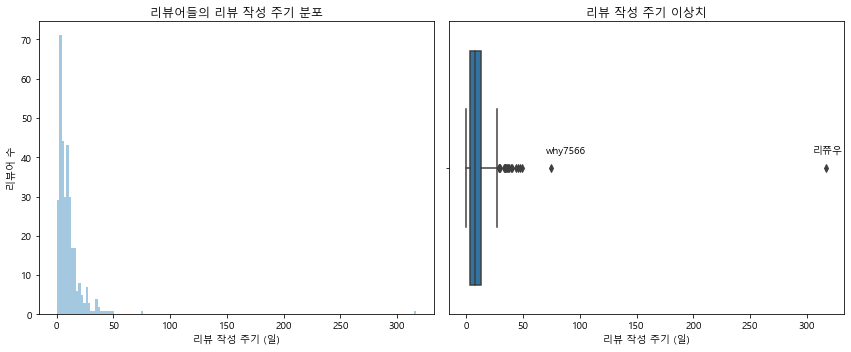

In [11]:
## subplot 설정
fig, axes = plt.subplots(1,2, figsize = (12,5))

## 그래프 그리기
sns.distplot(x = transaction.groupby("nickname").mean()["review_time_lag"], bins = 150, kde = False, ax= axes[0])
sns.boxplot(x = "review_time_lag", orient = "v", data = transaction.groupby("nickname").mean(), ax = axes[1])

## 그래프 제목 설정
axes[0].set_title("리뷰어들의 리뷰 작성 주기 분포")
axes[0].set_xlabel("리뷰 작성 주기 (일)")
axes[0].set_ylabel("리뷰어 수")

axes[1].set_xlabel("리뷰 작성 주기 (일)")
axes[1].set_title("리뷰 작성 주기 이상치")

## 그래프 내 닉네임 텍스트 넣기
axes[1].text(x = 305, y = -0.05,s = "리쮸우")
axes[1].text(x = 70.0, y = -0.05,s = "why7566")

plt.tight_layout()
plt.show()

In [12]:
transaction.groupby("nickname").mean()["review_time_lag"].reset_index().rename(columns = {"review_time_lag":"mean_review_time_lag"}).sort_values(by = "mean_review_time_lag", ascending = False)

,nickname,mean_review_time_lag
141,리쮸우,317.000000
60,why7566,74.923077
81,그콩,48.638298
187,새벽달구름,47.170213
283,쿠와아아앙,45.632653
...,...,...
146,먀맹이,NaN
151,모모22,NaN
157,믄지기,NaN
276,치치포포,NaN


In [13]:
## 리뷰어들의 리뷰 작성 주기 중앙값 

np.nanmedian(np.array(transaction.groupby("nickname").mean()["review_time_lag"]))

7.75

* 각 리뷰어 당 리뷰 작성 주기 평균이 50일 이내에 대부분 몰려 있음 
* 각 리뷰어 당 리뷰 작성 주기 평균 값들의 중앙값이 7.75임.즉, 리뷰어들이 평균적으로 7-8일 간격으로 리뷰를 작성함
* 수집한 리뷰어 데이터 내에서 리뷰 작성 주기가 300일이 넘는 이상치 데이터가 존재

* "리쮸우" 닉네임 유저 외에 "why7566" 닉네임 유저 또한 이상치로 볼 수 있으나, 리뷰 작성 텀이 평균적으로 75일 정도여서 극단적인 이상치로는 판단하지 않기로 함

In [14]:
transaction.loc[transaction.nickname == "리쮸우"][["nickname", "brand", "product_name", "rating", "review_date"]]

,nickname,brand,product_name,rating,review_date
6288,리쮸우,네이처리퍼블릭,바이플라워 트리플 무스 틴트,5,2018-01-09
6289,리쮸우,라보드레,인텐시브 리파이닝 에멀젼,4,2022-05-13
6290,리쮸우,허스텔러,원더 베지 멜로우 클렌징 밤,4,2022-05-13
6291,리쮸우,라로슈포제,유비데아 안뗄리오스 톤업 로지 [SPF50+/PA++++],3,2022-05-13
6292,리쮸우,시메스,노르딕 버치 에너지 에센스,4,2022-05-13
6293,리쮸우,에뛰드,플레이 컬러 아이즈 [뮬리로맨스],5,2022-05-13


* "리쮸우" 리뷰어는 2018년에 리뷰 작성 후 4년 정도의 휴면 기간을 가졌다가 최근에 다시 리뷰를 작성해서 평균 리뷰 작성 주기가 높게 산정이 되어 극단치로 분류됨
* 2018년에 작성한 리뷰를 제거하여 문제를 해결하기로 함

In [15]:
## 2018년에 리쮸우가 작성한 리뷰 데이터 제거

transaction.drop([6288], inplace = True)
transaction.index = range(transaction.shape[0])

transaction.iloc[6288, -1] = 0

In [16]:
## user_info 데이터 프레임에 파생 컬럼 생성(mean_review_time_lag)

user_info = pd.merge(user_info,transaction.groupby("nickname").mean()["review_time_lag"].reset_index(), on = "nickname")
user_info.rename(columns = {"review_time_lag":"mean_review_time_lag"}, inplace = True)

In [17]:
transaction.loc[transaction.nickname == "why7566"][["nickname", "brand", "product_name", "rating", "review_date"]]

,nickname,brand,product_name,rating,review_date
2578,why7566,롬앤,제로 매트 립스틱,4,2019-06-16
2579,why7566,웨이크메이크,디파이닝 커버 컨실러,4,2019-06-16
2580,why7566,릴리바이레드,스태리 아이즈 슬림 아이라이너,4,2019-06-16
2581,why7566,구달,청귤 비타C 잡티 세럼,4,2019-06-16
2582,why7566,클리오,킬 커버 에어리핏 컨실러,4,2019-06-16
2583,why7566,클리오,킬 커버 파운웨어 쿠션 XP [SPF50+/PA+++],4,2019-06-16
2584,why7566,페리페라,올테이크 무드 팔레트,4,2021-01-07
2585,why7566,삐아,라스트 벨벳 립 틴트3,4,2021-01-21
2586,why7566,아이소이,불가리안 로즈 블레미쉬 케어 세럼2 (잡티세럼2),4,2021-04-25
2587,why7566,한율,커버 파운데이션 [SPF15/PA+],4,2021-04-25


* why7566 유저의 경우 그냥 리뷰 텀이 상당히 긴 유저임. 이상치로 판단해 why7566 데이터는 제거하고 분석을 진행함

In [18]:
## why7566 삭제

user_info = user_info.loc[user_info.nickname != "why7566"]

user_info.index = range(user_info.shape[0])

### 3-3. 리뷰어들의 최근 리뷰 활동 파악

In [19]:
recency_table = transaction.sort_values(by = ["nickname","review_date"], ascending=False).groupby(["nickname"]).head(1)
recency_table.index = range(recency_table.shape[0])

recency_table["review_recency"] = [(datetime.strptime("2022-05-14", "%Y-%m-%d") - d).days for d in recency_table.review_date]

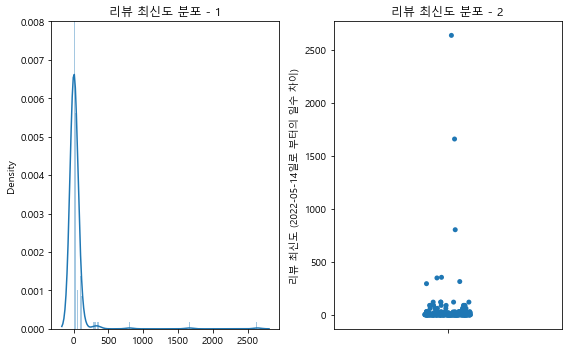

In [20]:
## subplot 설정
fig, axes = plt.subplots(1,2, figsize = (8,5))

## 그래프 그리기
sns.distplot(x = recency_table.review_recency, bins = 150, ax= axes[0])
sns.stripplot(data = recency_table, y = "review_recency", ax = axes[1])

## y축 범위 설정
axes[0].set_ylim([0,0.008])

## 축 제목 설정
axes[0].set_title("리뷰 최신도 분포 - 1")


axes[1].set_title("리뷰 최신도 분포 - 2")
axes[1].set_xlabel("")
axes[1].set_ylabel("리뷰 최신도 (2022-05-14일로 부터의 일수 차이)")


plt.tight_layout()
plt.show()

In [21]:
## IQR 기준으로 이상치 찾기
q1 = recency_table.review_recency.quantile(0.25)
q3 = recency_table.review_recency.quantile(0.75)

iqr = q3 - q1

outlier_num = recency_table.loc[recency_table.review_recency > (q3+1.5*iqr)].shape[0]


print("이상치로 간주되는 리뷰어 비율: {:.2f}%".format(outlier_num/recency_table.shape[0]*100))

이상치로 간주되는 리뷰어 비율: 11.98%


* 리뷰어 정보 수집일인 2022-05-14 일자를 기준으로 각 리뷰어 당, 가장 최신의 리뷰 작성일 사이의 시간 간격을 일 단위로 구하였음
* 리뷰어들의 "리뷰 최신도" 분포를 보면, 0일을 기준으로 대다수의 데이터가 몰려있음. 즉, 수집일 당일에 리뷰를 작성한 리뷰어들이 많았다는 의미
* 전체 리뷰어 중 11.98%의 비율로 상대적으로 오랜기간 동안 리뷰 작성 활동 기록이 없음
* 특히 리뷰 최신도 최하 3개 유저들인 "히호", "leena", "jsa" 를 보았을 떄 세 리뷰어 모두 2년이 넘는 기간동안 리뷰 작성 활동을 하지 않음
* 해당 리뷰어들이 휴면 계정 상태에 들어갔거나, 회원을 탈퇴한 것으로 예상할 수 있음

* 어느 정도의 긴 리뷰 텀이 이상치인가를 결정하는 것이 중요함. 단순히 q3+1.5 * iqr 을 넘는 값이라 하여 전체 데이터 중 11.98%에 해당 하는 모든 데이터를 삭제할 수 없음
* 현실적인 판단에 의해 이상치의 기준을 정하는 것이 중요

In [22]:
recency_table.sort_values(by = "review_recency", ascending = False).head(10)

,nickname,brand,product_name,rating,review_date,membership_period,review_date_shifted,review_time_lag,review_recency
0,히호,토니모리,크리스탈 블러셔,4,2015-02-23,2637,2015-01-21,33.0,2637
298,leena,스킨푸드,아보카도 & 올리브 립 밤,4,2017-10-28,1659,2017-10-27,1.0,1659
302,jsa,은율,메이크러버 아이섀도우 팔렛트,3,2020-03-02,803,2020-02-14,17.0,803
93,은곤듀,3CE,블러쉬 쿠션,4,2021-05-25,354,2020-05-07,383.0,354
105,영바,미쟝센,퍼펙트 세럼 오리지널,5,2021-05-31,348,2021-05-21,10.0,348
272,yeahjinn,웨이크메이크,수분 톡 틴트,3,2021-07-04,314,2021-03-29,97.0,314
323,Ruby,아임쏘리포마이스킨,아임 쏘리 포 마이 스킨 릴렉싱 크림 앰플,5,2021-07-24,294,2018-01-22,1279.0,294
3,히88,딥티크,오 드 퍼퓸 롬브르 단 로,4,2022-01-14,120,2018-01-11,1464.0,120
114,양말뒤집개,클리오,킬커버 뉴매트 파운데이션 [SPF20/PA++],4,2022-01-14,120,2021-08-17,150.0,120
189,맘moooooo_o,미샤,비폴렌 리뉴 앰풀러,5,2022-01-14,120,2020-02-20,694.0,120


In [23]:
## 이상치로 간주한 상위 7개 유저 제거

outliers_index = recency_table.sort_values(by = "review_recency", ascending = False).head(7).index

recency_table.drop(outliers_index, inplace = True)
recency_table.index  = range(recency_table.shape[0])

In [24]:
## user_info 데이터프레임에 review_recency 칼럼 추가 

user_info = user_info.merge(recency_table[["nickname", "review_recency"]], on = "nickname")

In [25]:
## mean_review_time_lag 의 NaN 값 제거 (리뷰가 하나밖에 없는 유저들은 전부 NaN으로 산정됨)

user_info.dropna(inplace=True)


### 3-4. user_info 데이터프레임에 파생컬럼 생성

In [26]:
## user_info 데이터프레임에 total_review_num 칼럼 추가

total_review_num_df = transaction.groupby(["nickname"]).count().reset_index()[["nickname", "review_date"]].rename(columns = {"review_date":"total_review_num"})

user_info = user_info.merge(total_review_num_df, on = "nickname")

## 4. user_info 데이터프레임 파일 출력

In [27]:
user_info.to_csv("user_info_new.csv")